In [1]:
#                        .::::.
#                      .::::::::.
#                     :::::::::::
#                  ..:::::::::::'
#               '::::::::::::'
#                 .::::::::::
#            '::::::::::::::..
#                 ..::::::::::::.
#               ``::::::::::::::::
#                ::::``:::::::::'        .:::.
#               ::::'   ':::::'       .::::::::.
#             .::::'      ::::     .:::::::'::::.
#            .:::'       :::::  .:::::::::' ':::::.
#           .::'        :::::.:::::::::'      ':::::.
#          .::'         ::::::::::::::'         ``::::.
#      ...:::           ::::::::::::'              ``::.
#     ```` ':.          ':::::::::'                  ::::..
#                        '.:::::'                    ':'````..
#                     美女保佑 永无BUG


In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from collections import OrderedDict
import sys
sys.path.insert(0, '/home/deepview/Workspace/XiaoY/PINNs-TF2.0/PINNs/Utilities/')
import os
import numpy as np
import json
import scipy.io
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = layers
        self.layer1 = nn.Sequential(nn.Linear(layers[0], layers[1]),nn.Tanh())
        self.layer2 = nn.Sequential(nn.Linear(layers[1], layers[2]),nn.Tanh())
        self.layer3 = nn.Sequential(nn.Linear(layers[2], layers[3]),nn.Tanh())
        self.layer4 = nn.Sequential(nn.Linear(layers[3], layers[4]),nn.Tanh())
        self.layer5 = nn.Sequential(nn.Linear(layers[4], layers[5]),nn.Tanh())
        self.layer6 = nn.Sequential(nn.Linear(layers[5], layers[6]),nn.Tanh())
        self.layer7 = nn.Sequential(nn.Linear(layers[6], layers[7]),nn.Tanh())
        self.layer8 = nn.Sequential(nn.Linear(layers[7], layers[8]),nn.Tanh())
        self.layer9 = nn.Sequential(nn.Linear(layers[8], layers[9]))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        return x

In [5]:
class PINNS(DNN):
    def __init__(self, X_u, u, layers, X_f, lb, ub, nu):
        super(PINNS, self).__init__(layers)
        #初始化数据
        self.nu = nu
        self.u = torch.tensor(u).float()
        self.lb = torch.tensor(lb).float()
        self.ub = torch.tensor(ub).float()
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad = True).float()
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad = True).float()
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad = True).float()
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad = True).float()
        self.dnn = DNN(layers)
        #将epoch初始化
        self.epoch = 0
        #设置LBFGS优化器，学习率为1，最大训练次数为5w次，终止梯度差1e-5
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       
        )

        #定义u（x，t）
    def u_model(self, x, t):
        u = self.dnn(torch.cat([x, t], dim = 1))
        return u
    
        #定义f（x，t）
    def f_model(self, x, t):
        u = self.u_model(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        #此时u_x为一个列表，所以在末尾加上[0]，得到tensor
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t + u * u_x - self.nu * u_xx
        return f

        #定义损失函数
    def loss_fun(self):
        self.optimizer.zero_grad()
        loss_u = torch.mean((self.u_model(self.x_u, self.t_u) - self.u)**2)
        loss_f = torch.mean((self.f_model(self.x_f, self.t_f)) **2)
        loss = loss_u + loss_f
        #反向传播
        loss.backward()

        self.epoch += 1
        #每一百次迭代输出损失函数的值
        if self.epoch % 100 ==0:
            print('Epoch:{}, loss_u:{:5e}, loss_f:{:5e}, loss:{:5e}'.format(self.epoch, loss_u.item(), loss_f.item(), loss.item()))
        
        return loss

        #训练函数
    def train(self):
        #self.dnn.train()
        self.optimizer.step(self.loss_fun)

        #模型预测
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad = True).float()
        t = torch.tensor(X[:, 1:2], requires_grad = True).float()
        self.dnn.eval()

        u = self.u_model(x, t)
        f = self.f_model(x, t)
        #detach(),阻断反向传播；cpu（）将数据放到cpu上；numpy（）将Tensor转化为numpy
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u,f

In [6]:
#数据处理，基本照搬原作者TensorFlow版
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('/home/deepview/Workspace/XiaoY/PINNs-TF2.0/1d-burgers/data\
/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
# 边界点
lb = X_star.min(0)
print(lb)
ub = X_star.max(0) 
print(ub)   

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]
#边界点
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
#内点+边界点
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])
#随机选择N_u个边界点
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

2
[-1.  0.]
[1.   0.99]


In [7]:
#建立模型
model = PINNS(X_u_train, u_train, layers, X_f_train, lb, ub, nu)

In [8]:
%%time
               
#开始训练
model.train()

Epoch:100, loss_u:5.167063e-02, loss_f:1.730055e-02, loss:6.897119e-02
Epoch:200, loss_u:2.958311e-02, loss_f:1.120578e-02, loss:4.078888e-02
Epoch:300, loss_u:6.546167e-03, loss_f:5.110643e-03, loss:1.165681e-02
Epoch:400, loss_u:2.005181e-03, loss_f:2.292499e-03, loss:4.297680e-03
Epoch:500, loss_u:7.924073e-04, loss_f:1.533308e-03, loss:2.325715e-03
Epoch:600, loss_u:2.987794e-04, loss_f:8.257115e-04, loss:1.124491e-03
Epoch:700, loss_u:1.817889e-04, loss_f:4.807090e-04, loss:6.624979e-04
Epoch:800, loss_u:9.434553e-05, loss_f:3.474915e-04, loss:4.418371e-04
Epoch:900, loss_u:5.976581e-05, loss_f:2.436134e-04, loss:3.033792e-04
Epoch:1000, loss_u:5.562670e-05, loss_f:1.750537e-04, loss:2.306804e-04
Epoch:1100, loss_u:4.209274e-05, loss_f:1.488673e-04, loss:1.909600e-04
Epoch:1200, loss_u:3.001100e-05, loss_f:1.227180e-04, loss:1.527290e-04
Epoch:1300, loss_u:2.385320e-05, loss_f:9.908326e-05, loss:1.229365e-04
Epoch:1400, loss_u:1.900903e-05, loss_f:8.097008e-05, loss:9.997911e-05
E

In [66]:
#获得预测值
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#输出误差
print('Error u: %e' % (error_u))                     
#对预测值进行插值
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 6.700455e-03


In [67]:
print(dict(model.named_parameters()))

01, -1.1665e-01, -1.5260e-01,  4.3837e-01,  3.7152e-01,
         -2.4705e-02, -4.1687e-01, -1.6317e-01,  1.2135e-01, -1.3475e-01,
         -6.1412e-01,  5.5866e-01, -7.9298e-01,  3.1131e-01,  5.7720e-01],
        [-1.3716e-01, -2.4813e-03, -2.5747e-01,  1.2570e-01,  1.2621e-01,
         -1.6621e-01, -4.9715e-02,  1.6401e-01, -1.3964e-01,  4.1290e-02,
         -2.3742e-01,  3.3671e-01,  7.0455e-02,  2.1092e-01,  2.6377e-01,
          9.9785e-02, -2.9578e-01,  1.8615e-01, -4.9656e-02,  9.7668e-02],
        [ 8.8567e-02,  2.1431e-01, -5.1778e-01, -1.8377e-01, -2.5654e-01,
         -1.5319e-01, -1.2473e-01,  1.1928e-01, -2.2560e-01,  1.8712e-02,
          2.3241e-01,  8.2662e-02,  1.7063e-01,  4.1646e-01,  3.5936e-02,
          5.3065e-01, -2.0371e-01, -4.2469e-02, -1.7577e-01,  1.1367e-01],
        [-8.7228e-02,  1.9773e-01, -6.4287e-03,  2.6486e-01, -2.2518e-01,
          1.1450e-01, -1.8982e-01, -4.9570e-02, -4.0628e-01,  7.9753e-02,
          8.1659e-02,  9.7858e-02, -2.1777e-02, -8.22

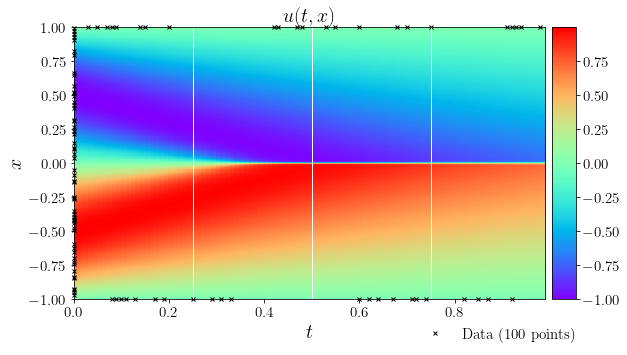

In [68]:
#画图，基本照搬原作者TensorFlow版
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

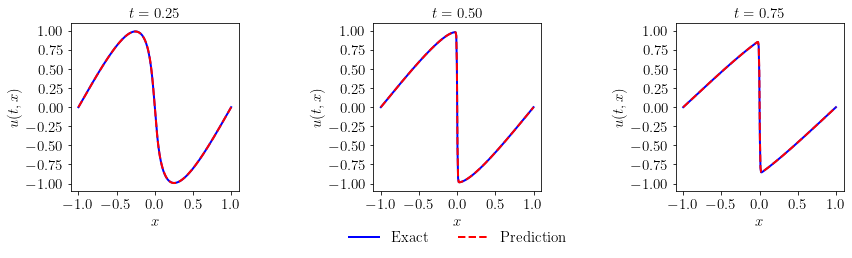

In [69]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()